### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File '03_df_bands_structure_VI_LAI_NDVIc.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

In this file, we will try to use all available predictants for model LAI, we have already generated VIs from a list.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.

- To visualize the results install Jinja2
```bash
conda install jinja2
```



### Running PySR 

Julia and Julia dependencies are installed at first import:

In [50]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [51]:
import sympy
import numpy as np
import skill_metrics as sm
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pandas as pd

import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

### Set up PySR run:


using Moises' data

In [52]:
df = pd.read_csv('03_df_bands_structure_VI_LAI_NDVIc.csv')
# print(df.head())
X = df.iloc[:,1:-3]
y = df.LAI
print(X.head())

        Red     Green      Blue       NIR        FC   c_depth        CH  \
0  0.035958  0.053953  0.005338  0.342562  0.439236  1.429447  1.972603   
1  0.035262  0.053063  0.005320  0.340711  0.383681  1.474576  1.946317   
2  0.038239  0.053274  0.005266  0.329618  0.274306  1.550626  1.988539   
3  0.039237  0.053812  0.005251  0.324419  0.307292  1.559624  2.024439   
4  0.038143  0.049900  0.005562  0.285435  0.130208  1.447568  1.946801   

        AVI        BAI       BCC  ...        SI        SR       SR2      TDVI  \
0  0.466092  11.912866  0.056041  ...  0.968043  9.526727  6.349293  0.568998   
1  0.464776  12.049737  0.056810  ...  0.968585  9.662140  6.420823  0.567705   
2  0.452042  13.070470  0.054412  ...  0.967534  8.619965  6.187242  0.543420   
3  0.446288  13.585168  0.053416  ...  0.967021  8.268284  6.028801  0.532854   
4  0.407953  18.299150  0.059423  ...  0.968618  7.483366  5.720179  0.471239   

        TGI       TVI      TriVI      VARI       VIG   VgNIRBI

The default parameters will help speed up code and ensure repeteability of run

In [53]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [54]:
# Learn equations
model = PySRRegressor(
    niterations=100,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=3600*2,  # this line will make the code stop after 2 hours
    binary_operators=["+", "*","-","/"], # these are the default binary operators (use these for basic equations)
    # binary_operators=["+", "*","-","/","nd(x,y) = ((x-y)/(x+y))", "sr(x,y)=x/y"], # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    # unary_operators=["sqrt", "exp", "log", "inv(x)=1/x"], # other basic operators can be added here
    extra_sympy_mappings={"inv": lambda x: 1 / x,"nd": lambda x, y: ((x- y)/(x+y)),"sr": lambda x, y: x/y}, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)


c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367404   
	1         0.325454                                      3.435755 / CH   
	2         0.090218                      (CH * -2.0666356) + 5.5965366   
	3         0.204743                ((FC + 2.2035308) - CH) * 2.3526683   
	4         0.017481        (FC + (2.2437394 - CH)) * (FCVI + 1.885452)   
	5         0.005567  (((FC - CH) + 1.6852956) * (RDVI * 4.1675053))...   
	6         0.008909  (TDVI * ((2.2786114 - CH) * 3.209134)) + ((FC ...   
	7         0.005873  (NDTI + ((((2.0617633 - CH) * TDVI) * 3.318440...   
	8         0.014816  (NormG + ((FC / GARI) + RDVI)) * ((((-2.986894...   
	9         0.005898  ((((((FCVI * -4.5960207) - 1.1343195) / CH) + ...   
	10        0.000228  (((((((-4.203829 - DVI) * FCVI) - 1.1343195) /...   
	11        0.020964  (1.8662288 / CH) + (((1.777272 / (((CH * (CH +...   
	12        0.012996  (1.9625758 / CH) + ((FC - ExR) * (TVI * (1.655...   
	13        0.004851  ((GEMI * ((CH + 0.7660939) / (GARI + (((CH + -...   
	14        0.019243  ((FC * (2.550021 / ((((CH - GARI) + -1.0828505...   
	15        0.029122  (FC * (2.3419983 / (((((CH * 1.308079) - GARI)...   
	16        0.001423  (((FC * (2.7463038 / (GARI + ((((CH * 1.274432...   
	17        0.019688  ((1.8516555 / (GARI + (((((CH - NormNIR) / GOS...   
	18  >>>>  0.038158  (2.2540913 / (CH / GARI)) + (1.7476614 * (FC /...   
	19        0.001589  ((2.2540913 / (CH / GARI)) - Blue) + (1.747661...   
	20        0.000249  ((((FC / ((((((SI * CH) - NormNIR) / GOSAVI) +...   
	21        0.002048  ((1.7476614 / (GARI + (((((SI * CH) - NormNIR)...   
	
	        loss  complexity  
	0   1.291320           1  
	1   0.673516           3  
	2   0.562323           5  
	3   0.373378           7  
	4   0.360549           9  
	5   0.356557          11  
	6   0.350260          13  
	7   0.346170          15  
	8   0.336063          17  
	9   0.332122          19  
	10  0.331971          21  
	11  0.318340          23  
	12  0.310172          25  
	13  0.307178          27  
	14  0.295581          29  
	15  0.278857          31  
	16  0.278064          33  
	17  0.267328          35  
	18  0.247686          37  
	19  0.246900          39  
	20  0.246777          41  
	21  0.245768          43  
]

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [55]:
best_score=model.get_best().score

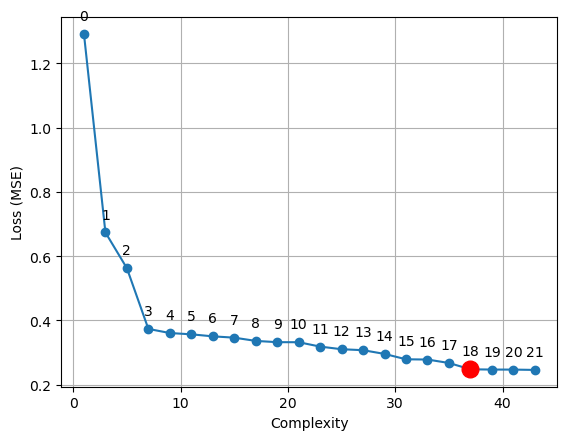

In [56]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [57]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

1.7476614*FC/(GARI + (-FC - 1.1771448 + (CH*SI - NormNIR)/GOSAVI)/((2.4596415/(CH*(FC/(-1.2029934) + SI)/0.2432683 - 1.8121377)))) + 2.2540913/((CH/GARI))

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [58]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291320,2.367404
1,0.673516,3.435755 / CH
2,0.562323,(CH * -2.0666356) + 5.5965366
3,0.373378,((FC + 2.2035308) - CH) * 2.3526683
4,0.360549,(FC + (2.2437394 - CH)) * (FCVI + 1.885452)
5,0.356557,(((FC - CH) + 1.6852956) * (RDVI * 4.1675053)) - -1.2377063
6,0.350260,(TDVI * ((2.2786114 - CH) * 3.209134)) + ((FC / 0.37298965) + NDTI)
7,0.346170,(NDTI + ((((2.0617633 - CH) * TDVI) * 3.3184404) + (FC / 0.38347822))) - -0.43537384
8,0.336063,(NormG + ((FC / GARI) + RDVI)) * ((((-2.9868946 / CH) + 8.843397) / CH) - 2.352132)
9,0.332122,((((((FCVI * -4.5960207) - 1.1343195) / CH) + 9.351091) / CH) - 2.5104413) * (MCARI1 + (FC / GARI))


## Output

Plotting the first solutions

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\mpl_scatter_density\scatter_density_axes.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.set_xlim(np.min(x), np.max(x))
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
c:\Users\alfon\.conda\envs\PySR\Lib\site

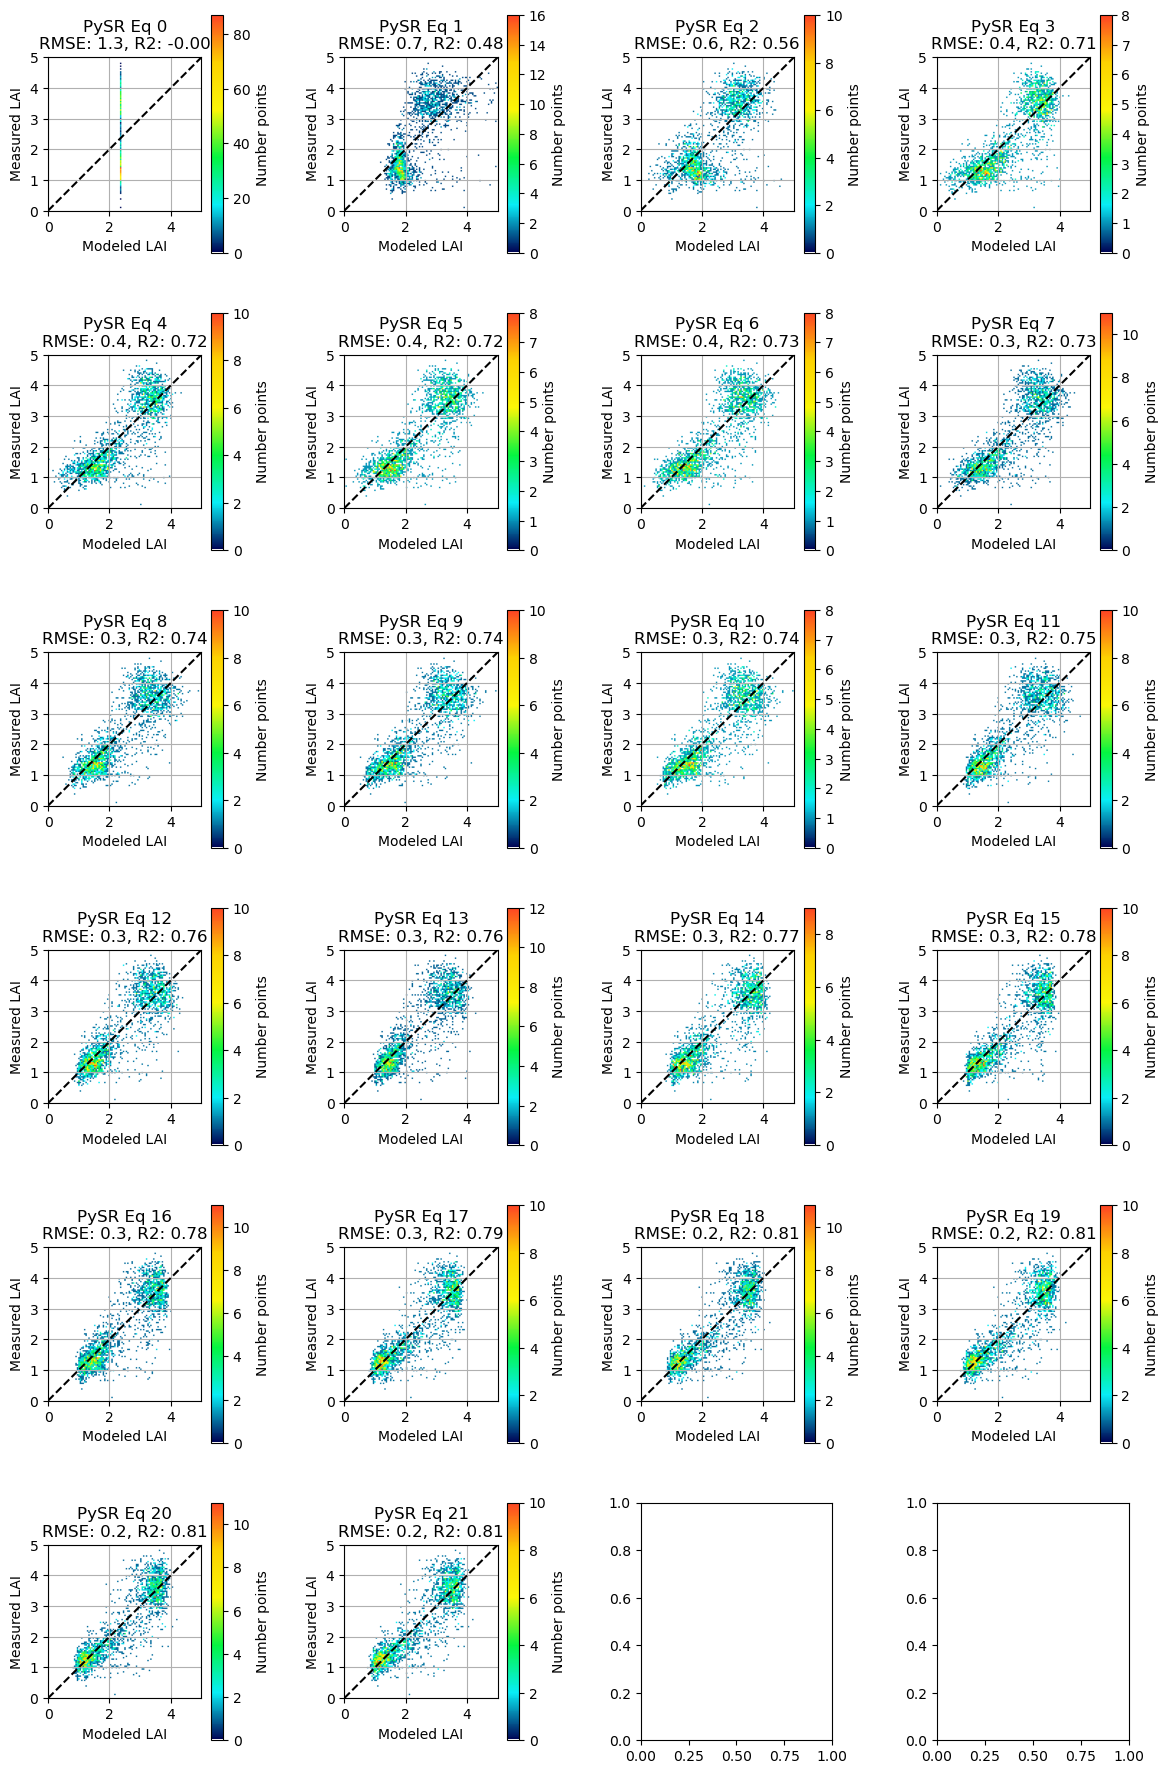

In [59]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#000153"),
    (0.2, "#08EEF6"),
    (0.4, "#05f541"),
    (0.6, "#faf607"),
    (0.8, "#fcd201"),
    (1, "#fd4424"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled LAI")
    ax.set_ylabel("Measured LAI")
    ax.plot( [0,5], [0,5], linestyle='--', color='k' )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    rmse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nRMSE: {rmse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



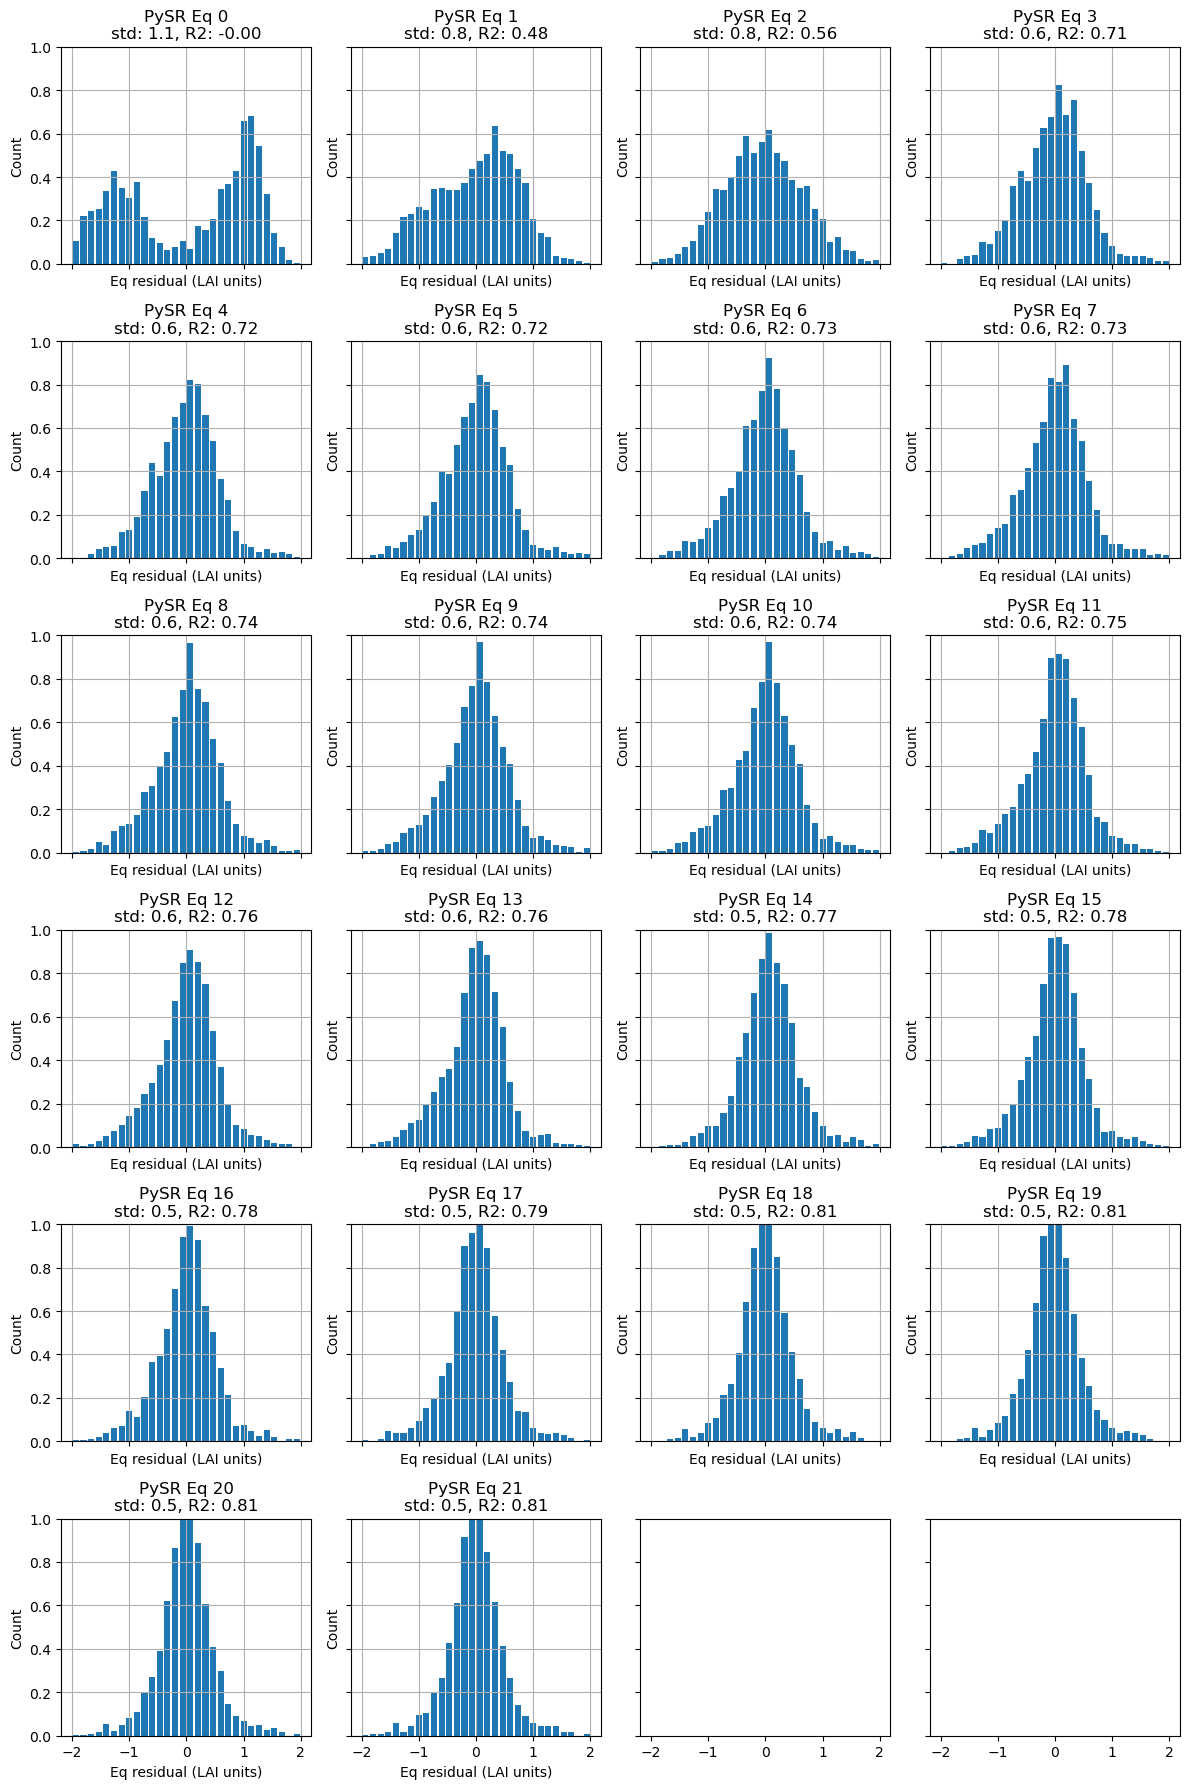

In [63]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y,range=(-2,2), bins=30,density=True,rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (LAI units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Create a Taylor diagram with labeled data points and modified axes

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


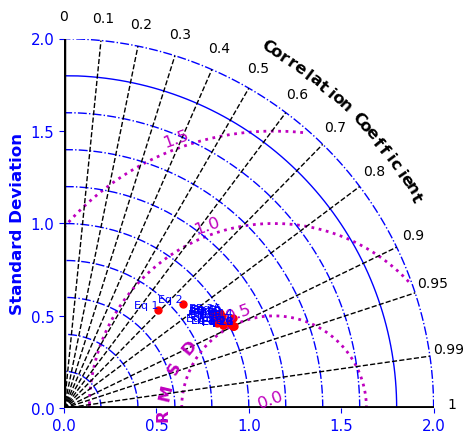

In [61]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api